# 创新探索方向：模型架构-多模态融合方法

### 1.数据预处理、特征提取部分

In [1]:
import re
from torchvision import transforms
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from transformers import BertModel
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# 文本清理函数
def clean_text(text):
    text = text.lower() # 小写
    text = re.sub(r'\s+', ' ', text)   # 去除多余空格
    text = text.strip() # 去除首尾空格
    return text

# 图像预处理
image_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 调整图像大小
    transforms.ToTensor(), # 转换为 PyTorch 张量
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # 标准化参数
        std=[0.229, 0.224, 0.225]
    )
])
# 数据集构建与训练
class MultimodalDataset(Dataset): # 多模态数据集类
    def __init__(self, data_list, image_dir, text_dir, tokenizer, transform=None):
        self.data_list = data_list   # [(guid, label)]
        self.image_dir = image_dir   # 图像文件夹路径
        self.text_dir = text_dir     # 文本文件夹路径
        self.tokenizer = tokenizer   # 文本分词器
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx): # 获取单个数据样本
        guid, label = self.data_list[idx]
        # 文本清洗处理
        with open(os.path.join(self.text_dir, f"{guid}.txt"), encoding="Latin-1") as f:
            text = clean_text(f.read())

        # 文本编码,转换为PyTorch张量
        text_input = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        # 图像处理
        img_path = os.path.join(self.image_dir, f"{guid}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # 文本特征、图像和标签
        return {
            "input_ids": text_input["input_ids"].squeeze(0),
            "attention_mask": text_input["attention_mask"].squeeze(0),
            "image": image,
            "label": label
        }

# 数据加载
def load_train_data(train_file):
    data = []
    label_map = {
        "negative": 0,
        "neutral": 1,
        "positive": 2
    }
    # 读取训练数据
    with open(train_file, encoding="Latin-1") as f:
        for line in f:
            if line.startswith('guid'): # 跳过表头
                continue 
            guid, label = line.strip().split(',')
            data.append((guid, label_map[label])) # 存入data列表
    return data

def load_test_data(test_file):
    data = []
    # 读取测试数据
    with open(test_file, encoding="Latin-1") as f:
        for line in f:
            if line.startswith('guid'): # 跳过表头
                continue 
            parts = line.strip().split(',')
            guid = parts[0].strip()
            data.append((guid, -1)) # 测试集标签未知，设为-1
    return data

all_data = load_train_data("project5/train.txt")
# 划分训练集、验证集、测试集
train_data, val_data = train_test_split(
    all_data,
    test_size=0.2,
    random_state=408,
    stratify=[label for _, label in all_data] # 保持标签分布一致
)
test_data=load_test_data("project5/test_without_label.txt")

# 加载预训练的 BERT 文本编码器
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  

train_dataset = MultimodalDataset(
    train_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform
)

val_dataset = MultimodalDataset(
    val_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform
)

test_dataset = MultimodalDataset(
    test_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform
)
# 数据加载器：训练集 验证集 测试集
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

d:\Python2\Python311\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# 文本编码器（BERT）
class TextEncoder(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super().__init__()
        # 加载预训练的 BERT 模型
        self.bert = BertModel.from_pretrained(model_name)

    # 前向传播（词索引，注意力掩码）
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_feat = outputs.last_hidden_state[:, 0, :]  # 提取全局特征token
        return cls_feat     # shape: (B, 768)
    
# 图像编码器（ResNet18）
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 预训练的 ResNet18 模型
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # 去掉最后的全连接层

    def forward(self, image):
        feat = self.resnet(image) # 提取图像特征
        return feat     # shape: (B, 512)

### 2. 多模态融合方法

Late Fusion（后期融合）:

各模态完全独立提取高层语义特征 → 融合操作仅发生在高层特征阶段 → 融合后送下游分类

In [4]:
# 拼接融合（Concat Fusion）
class ConcatfusionModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # 文本与图像编码器
        self.text_encoder = TextEncoder()
        self.image_encoder = ImageEncoder()
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(768 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # 进一步抑制过拟合
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # 文本和图像特征
        text_feat = self.text_encoder(input_ids, attention_mask)
        image_feat = self.image_encoder(image)
        # 融合特征
        fused_feat = torch.cat([text_feat, image_feat], dim=1)
        # 分类器预测
        logits = self.classifier(fused_feat)
        return logits

In [4]:
# 加权拼接融合（Weighted Concat Fusion）
class WeightedConcatFusionModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # 文本与图像编码器
        self.text_encoder = TextEncoder()
        self.image_encoder = ImageEncoder()
        
        # 融合权重参数
        self.text_weight = nn.Parameter(torch.tensor(0.5))
        self.image_weight = nn.Parameter(torch.tensor(0.5))
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(768 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # 进一步抑制过拟合
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # 文本和图像特征
        text_feat = self.text_encoder(input_ids, attention_mask)
        image_feat = self.image_encoder(image)
        
        # 加权融合特征（权重约束）
        fused_feat = torch.cat([
            torch.sigmoid(self.text_weight) * text_feat,
            torch.sigmoid(self.image_weight) * image_feat
        ], dim=1)
        
        # 分类器预测
        logits = self.classifier(fused_feat)
        return logits

In [6]:
# 自注意力融合（self-attention）
class SelfAttentionFusionModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # 文本与图像编码器
        self.text_encoder = TextEncoder()
        self.image_encoder = ImageEncoder()
        
        # 自注意力融合层
        self.attention = nn.MultiheadAttention(embed_dim=1280, num_heads=4, batch_first=True)
        
        self.norm1=nn.LayerNorm(1280)
        self.norm2=nn.LayerNorm(1280)


        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # 文本和图像特征
        text_feat = self.text_encoder(input_ids, attention_mask)
        image_feat = self.image_encoder(image)
        
        # 拼接融合特征
        fused_feat = torch.cat([text_feat, image_feat], dim=1)
        x=fused_feat.unsqueeze(1)       # shape: (B, 1, 1280)
        # 自注意力、残差连接、层归一化
        ttn_q = self.norm1(x).clone()
        attn_k = self.norm1(x).clone()
        attn_v = self.norm1(x).clone()
        attn_output, _ = self.attention(ttn_q, attn_k, attn_v)
       
        x = torch.add(x, attn_output)
        x=self.norm2(x).clone()
        
         # 去掉序列维度
        attn_output = x.squeeze(1)  # shape: (B, 1280)
        
        # 分类器预测
        logits = self.classifier(attn_output)
        return logits

Early Fusion（早期融合）

底层/中间层早期特征融合，融合后用统一的编码器做联合高层特征提取

In [7]:
# 特征投影融合（Early Fusion）
class EarlyFusionModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # 文本与图像编码器
        self.text_encoder = TextEncoder()
        self.image_encoder = ImageEncoder()

        # 特征归一化
        self.text_norm = nn.LayerNorm(768)
        self.image_norm = nn.LayerNorm(512)

        # 联合编码器（统一联合编码）
        self.joint_encoder = nn.Sequential(
            nn.Linear(768 + 512, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.LayerNorm(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.LayerNorm(512)
        )
        # 分类器：联合编码器输出到类别数
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # 文本和图像特征
        text_feat = self.text_encoder(input_ids, attention_mask)
        image_feat = self.image_encoder(image)
        
        # 归一化
        text_feat=self.text_norm(text_feat)
        image_feat=self.image_norm(image_feat)
        
        # early 融合特征
        fused_early_feat = torch.cat([text_feat, image_feat], dim=1) 
        # 联合编码器处理
        joint_feat = self.joint_encoder(fused_early_feat)
        # 分类器预测
        logits = self.classifier(joint_feat)
        return logits

CLIP 

CLIP 的核心是「编码器→投影层→L2 归一化→跨模态对齐」

In [8]:
# CLIP（图文特征对齐+归一化融合）
class CLIPFusionModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # 文本与图像编码器
        self.text_encoder = TextEncoder()
        self.image_encoder = ImageEncoder()
        
        # 特征投影
        self.text_proj=nn.Linear(768,512)
        self.image_proj=nn.Linear(512,512)

        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # 进一步抑制过拟合
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # 文本和图像特征
        text_feat = self.text_encoder(input_ids, attention_mask)
        image_feat = self.image_encoder(image)
        
        # 特征投影
        text_proj=self.text_proj(text_feat)
        image_proj=self.image_proj(image_feat)

        # 特征归一化
        text_clip=text_proj/text_proj.norm(dim=1, keepdim=True)
        image_clip=image_proj/image_proj.norm(dim=1, keepdim=True)
        
        # 融合特征（拼接）
        fused_feat = torch.cat([text_clip, image_clip], dim=1)
        
        # 分类器预测
        logits = self.classifier(fused_feat)
        return logits

BLIP

视觉引导的文本理解，用图像特征去引导文本特征的注意力

In [9]:
# BLIP（图像引导文本注意力+融合）
class BLIPFusionModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.text_encoder = TextEncoder()
        self.image_encoder = ImageEncoder()

        # 图像引导注意力层+归一化
        self.vis_guide_attn = nn.Sequential(
            nn.Linear(512, 768),  # 图像512维→文本768维，维度匹配
            nn.LayerNorm(768),  
            nn.Sigmoid()  # 生成0-1的注意力权重
        )
        # 融合层：拼接后轻量线性变换
        self.fusion_proj = nn.Linear(768+512, 1024)
        self.fusion_norm = nn.LayerNorm(1024) 

        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),nn.
            Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        text_feat = self.text_encoder(input_ids, attention_mask)  # (B,768)
        image_feat = self.image_encoder(image)                    # (B,512)

        # 图像生成文本权重
        text_attn_weight = self.vis_guide_attn(image_feat)  # (B,768)
        text_feat = text_feat * text_attn_weight  # 加权文本特征，保留和图像相关的部分

        # 拼接融合+BLIP线性变换
        fused_feat = torch.cat([text_feat, image_feat], dim=1)  # (B,1280)
        fused_feat = self.fusion_proj(fused_feat)  # (B,1024)
        fused_feat = self.fusion_norm(fused_feat)

        logits = self.classifier(fused_feat)
        return logits

In [10]:
# BLIPV2 双向引导 BLIP
class BLIPV2FusionModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.text_encoder = TextEncoder()
        self.image_encoder = ImageEncoder()

        # 双向引导注意力层
        # 图像引导注意力层：用图像特征生成文本特征的注意力权重
        self.vis_guide_attn = nn.Sequential(
            nn.Linear(512, 768),
            nn.LayerNorm(768),
            nn.Sigmoid()  # 0-1的注意力权重
        )
        # 文本引导注意力层：用文本特征生成图像特征的注意力权重
        self.text_guide_attn = nn.Sequential(
            nn.Linear(768, 512),  
            nn.LayerNorm(512),  
            nn.Sigmoid()
        )
        # 融合层：拼接后轻量线性变换
        self.fusion_proj = nn.Linear(768+512, 1024)
        self.fusion_norm = nn.LayerNorm(1024) 

        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        text_feat = self.text_encoder(input_ids, attention_mask)  # (B,768)
        image_feat = self.image_encoder(image)                    # (B,512)

        # 双向引导注意力
        text_attn_weight = self.vis_guide_attn(image_feat)  # (B,768)
        image_attn_weight = self.text_guide_attn(text_feat)  # (B,512)

        text_feat = text_feat * text_attn_weight  # 加权文本特征
        image_feat = image_feat * image_attn_weight  # 加权图像特征

        # 拼接融合+线性变换
        fused_feat = torch.cat([text_feat, image_feat], dim=1)
        fused_feat = self.fusion_proj(fused_feat) 
        fused_feat = self.fusion_norm(fused_feat)

        logits = self.classifier(fused_feat)
        return logits

### 3.运行验证集测试效果

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPFusionModel().to(device)
print(device)
batch = next(iter(train_loader))
logits = model(
    batch["input_ids"].to(device),
    batch["attention_mask"].to(device),
    batch["image"].to(device)
)

print(logits.shape)  # 应该是 (batch_size, 3)


d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda
torch.Size([16, 3])


### 3. 训练与可视化分析

In [5]:
# 单轮训练
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_batches = len(dataloader)  
    accumulate_steps = 2
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx,batch in enumerate(dataloader):
        optimizer.zero_grad() # 清空梯度
        # 获取数据
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        # 前向传播：混合精度
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss = loss / accumulate_steps  # 梯度均分

        # 反向传播：混合精度缩放
        scaler.scale(loss).backward()

        # 每累积2步更新一次参数（等效32batch）
        if (batch_idx + 1) % accumulate_steps == 0 or batch_idx == total_batches - 1:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulate_steps
    torch.cuda.empty_cache()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask, images)
            preds = torch.argmax(logits, dim=1)

            # 计算当前batch的损失
            batch_loss = criterion(logits, labels)  # 计算单batch损失
            # 累积损失
            total_loss += batch_loss.item()
            # 正确率计算
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total, total_loss / len(dataloader)

In [ ]:
import pandas as pd
from torch.optim import AdamW

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoch = 10

MODEL_LIST = [
    ("拼接融合", ConcatfusionModel),
    ("加权拼接融合", WeightedConcatFusionModel),
    ("自注意力融合", SelfAttentionFusionModel),
    ("早期融合", EarlyFusionModel),
    ("CLIP融合", CLIPFusionModel),
    ("BLIP融合", BLIPFusionModel),
    ("BLIP进阶融合", BLIPV2FusionModel)
]

criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 

total_results = {
    model_name: {
        "epochs": [],
        "train_loss": [],
        "val_loss": [],
        "val_acc": []
    } for model_name, _ in MODEL_LIST
}

for model_name, ModelClass in MODEL_LIST:
    print(f"\n开始训练：{model_name}")
    print("-" * 20)
    # 初始化优化器
    model = ModelClass(num_classes=3).to(device)
    
    optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=3e-4)
    # 逐轮训练
    for epoch0 in range(epoch):

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_acc, val_loss = evaluate(model, val_loader, device, criterion)

        total_results[model_name]["epochs"].append(epoch0)
        total_results[model_name]["train_loss"].append(round(train_loss, 4))
        total_results[model_name]["val_loss"].append(round(val_loss, 4))
        total_results[model_name]["val_acc"].append(round(val_acc, 4))

        print(f"轮数 {epoch0:2d}/{epoch} | 训练损失 {train_loss:.4f} | 验证损失 {val_loss:.4f} | 验证准确率 {val_acc:.4f}")
    
    # 清空CUDA缓存，释放显存
    torch.cuda.empty_cache()
    print(f"{model_name} 训练完成")
    print("-" * 20)



开始训练：拼接融合
--------------------
轮数  0/10 | 训练损失 0.9378 | 验证损失 0.8643 | 验证准确率 0.5988
轮数  1/10 | 训练损失 0.8129 | 验证损失 0.7543 | 验证准确率 0.7325
轮数  2/10 | 训练损失 0.7143 | 验证损失 0.8254 | 验证准确率 0.6787
轮数  3/10 | 训练损失 0.6147 | 验证损失 0.7448 | 验证准确率 0.7462
轮数  4/10 | 训练损失 0.5226 | 验证损失 0.7787 | 验证准确率 0.7425
轮数  5/10 | 训练损失 0.4513 | 验证损失 0.7755 | 验证准确率 0.7375
轮数  6/10 | 训练损失 0.4015 | 验证损失 0.8048 | 验证准确率 0.7375
轮数  7/10 | 训练损失 0.3777 | 验证损失 0.8472 | 验证准确率 0.7175
轮数  8/10 | 训练损失 0.3628 | 验证损失 0.8347 | 验证准确率 0.7338
轮数  9/10 | 训练损失 0.3500 | 验证损失 0.7941 | 验证准确率 0.7400
拼接融合 训练完成
--------------------

开始训练：加权拼接融合
--------------------
轮数  0/10 | 训练损失 0.9176 | 验证损失 0.8204 | 验证准确率 0.6925
轮数  1/10 | 训练损失 0.7919 | 验证损失 0.7595 | 验证准确率 0.7238
轮数  2/10 | 训练损失 0.6910 | 验证损失 0.7441 | 验证准确率 0.7350
轮数  3/10 | 训练损失 0.5907 | 验证损失 0.7432 | 验证准确率 0.7450
轮数  4/10 | 训练损失 0.5047 | 验证损失 0.7833 | 验证准确率 0.7550
轮数  5/10 | 训练损失 0.4492 | 验证损失 0.8003 | 验证准确率 0.7388
轮数  6/10 | 训练损失 0.4115 | 验证损失 0.8068 | 验证准确率 0.7438
轮数  7/10 | 训练损失 0.3

In [27]:
# 上面实验设置过程出现问题，导致轮次epochs全部变为10， 现在重新修正！
for model_name, ModelClass in MODEL_LIST:
    total_results[model_name]["epochs"]=[]
    for epoch0 in range(epoch):
        total_results[model_name]["epochs"].append(epoch0+1)
print(total_results)

{'拼接融合': {'epochs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'train_loss': [0.9378, 0.8129, 0.7143, 0.6147, 0.5226, 0.4513, 0.4015, 0.3777, 0.3628, 0.35], 'val_loss': [0.8643, 0.7543, 0.8254, 0.7448, 0.7787, 0.7755, 0.8048, 0.8472, 0.8347, 0.7941], 'val_acc': [0.5988, 0.7325, 0.6787, 0.7462, 0.7425, 0.7375, 0.7375, 0.7175, 0.7338, 0.74]}, '加权拼接融合': {'epochs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'train_loss': [0.9176, 0.7919, 0.691, 0.5907, 0.5047, 0.4492, 0.4115, 0.3788, 0.3506, 0.3438], 'val_loss': [0.8204, 0.7595, 0.7441, 0.7432, 0.7833, 0.8003, 0.8068, 0.8142, 0.8179, 0.7967], 'val_acc': [0.6925, 0.7238, 0.735, 0.745, 0.755, 0.7388, 0.7438, 0.7338, 0.7462, 0.7575]}, '自注意力融合': {'epochs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'train_loss': [0.9135, 0.7736, 0.6687, 0.5742, 0.4855, 0.4653, 0.4066, 0.3861, 0.3756, 0.3622], 'val_loss': [0.7835, 0.7311, 0.7391, 0.7914, 0.8193, 0.7887, 0.8344, 0.8245, 0.8579, 0.7993], 'val_acc': [0.71, 0.7438, 0.7512, 0.7175, 0.7262, 0.7388, 0.7262, 0.7462, 0.7475, 0.7488]

In [28]:
df_list = []
for model_name, res in total_results.items():
    df = pd.DataFrame({
        "模型名称": [model_name] * len(res["epochs"]),
        "训练轮数": res["epochs"],
        "训练损失": res["train_loss"],
        "验证损失": res["val_loss"],
        "验证准确率": res["val_acc"]
    })
    df_list.append(df)
all_results_df = pd.concat(df_list, ignore_index=True)

csv_save_path = "model_training_results.csv"
all_results_df.to_csv(csv_save_path, index=False, encoding="utf-8-sig")
print(f"所有模型训练结果已保存为：{csv_save_path}")

print(f"\n【各模型最优验证准确率对比】")
print("-" * 60)
for model_name in total_results.keys():
    res = total_results[model_name]
    best_val_acc = max(res["val_acc"])
    best_epoch = res["epochs"][res["val_acc"].index(best_val_acc)]
    best_train_loss = res["train_loss"][res["val_acc"].index(best_val_acc)]
    best_val_loss = res["val_loss"][res["val_acc"].index(best_val_acc)]
    print(f"{model_name:<12} | 最优准确率：{best_val_acc:.4f}（第{best_epoch}轮） | 对应训练损失：{best_train_loss:.4f} | 对应验证损失：{best_val_loss:.4f}")
print("-" * 60)


所有模型训练结果已保存为：model_training_results.csv

【各模型最优验证准确率对比】
------------------------------------------------------------
拼接融合         | 最优准确率：0.7462（第4轮） | 对应训练损失：0.6147 | 对应验证损失：0.7448
加权拼接融合       | 最优准确率：0.7575（第10轮） | 对应训练损失：0.3438 | 对应验证损失：0.7967
自注意力融合       | 最优准确率：0.7512（第3轮） | 对应训练损失：0.6687 | 对应验证损失：0.7391
早期融合         | 最优准确率：0.7488（第9轮） | 对应训练损失：0.3992 | 对应验证损失：0.9907
CLIP融合       | 最优准确率：0.7063（第9轮） | 对应训练损失：0.4233 | 对应验证损失：0.8834
BLIP融合       | 最优准确率：0.7438（第4轮） | 对应训练损失：0.6333 | 对应验证损失：0.7472
BLIP进阶融合     | 最优准确率：0.7462（第4轮） | 对应训练损失：0.5670 | 对应验证损失：0.7683
------------------------------------------------------------


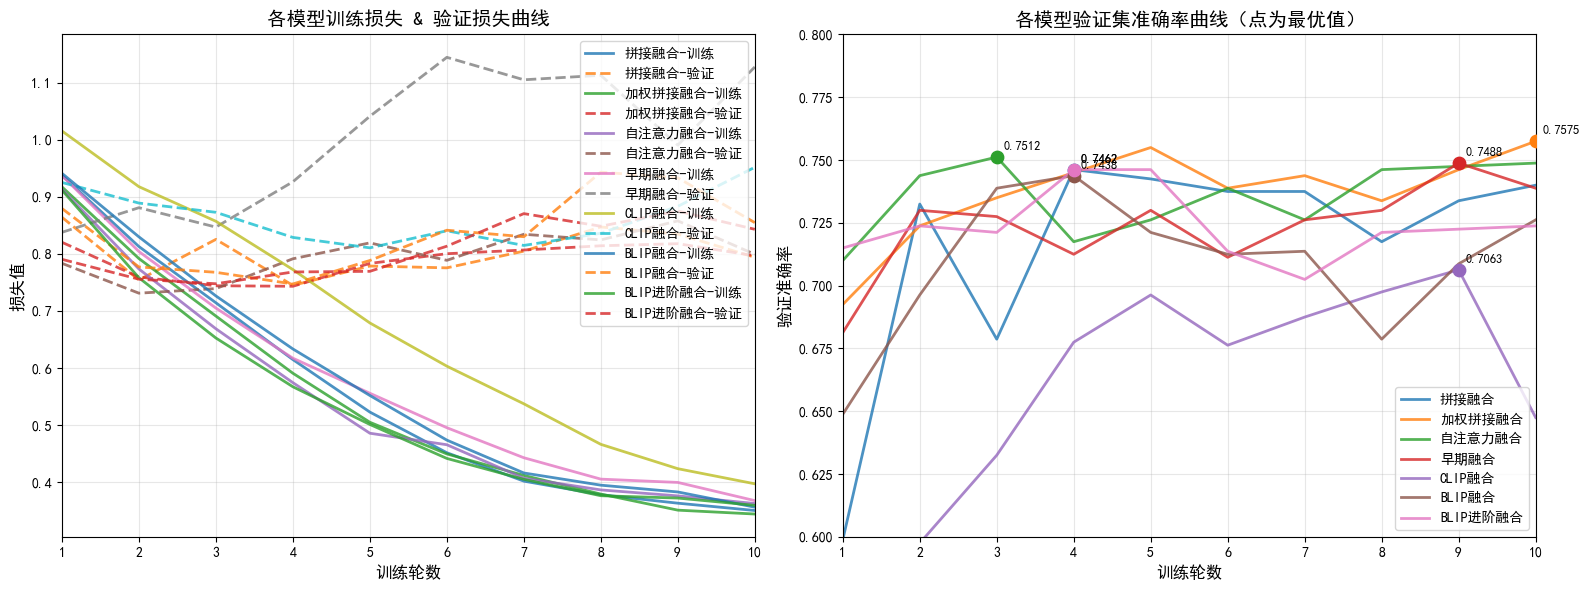

训练曲线已保存为：model_training_curves.png


In [31]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (16, 6)

# 子图1：训练损失 + 验证损失曲线
plt.subplot(1, 2, 1)
for model_name, res in total_results.items():
    plt.plot(res["epochs"], res["train_loss"], label=f"{model_name}-训练", linewidth=2, alpha=0.8)
    plt.plot(res["epochs"], res["val_loss"], label=f"{model_name}-验证", linewidth=2, linestyle="--", alpha=0.8)
plt.title("各模型训练损失 & 验证损失曲线", fontsize=14, fontweight="bold")
plt.xlabel("训练轮数", fontsize=12)
plt.ylabel("损失值", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(1, 10)

# 子图2：验证集准确率曲线
plt.subplot(1, 2, 2)
for model_name, res in total_results.items():
    plt.plot(res["epochs"], res["val_acc"], label=model_name, linewidth=2, alpha=0.8)
# 标注各模型最优准确率点
for model_name, res in total_results.items():
    best_val_acc = max(res["val_acc"])
    best_epoch = res["epochs"][res["val_acc"].index(best_val_acc)]
    plt.scatter(best_epoch, best_val_acc, s=80, zorder=5)
    plt.annotate(f"{best_val_acc:.4f}", (best_epoch, best_val_acc), xytext=(5, 5), textcoords="offset points", fontsize=9)
plt.title("各模型验证集准确率曲线（点为最优值）", fontsize=14, fontweight="bold")
plt.xlabel("训练轮数", fontsize=12)
plt.ylabel("验证准确率", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(1, 10)
plt.ylim(0.6, 0.8)

# 保存图片（保存在当前目录，高清）
plt.tight_layout()
img_save_path = "model_training_curves.png"
plt.savefig(img_save_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print(f"训练曲线已保存为：{img_save_path}")

### 4. 数据增强与最优模型训练测试集

In [7]:
# 数据增强
image_transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomRotation(degrees=10),   # 随机旋转±10°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 色彩抖动
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_aug = MultimodalDataset(
    train_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform_aug
)

train_aug_loader = DataLoader(train_dataset_aug, batch_size=16, shuffle=True)

In [9]:
import pandas as pd
from torch.optim import AdamW



def train_model(ModelClass,train_loader,val_loader) :   
    # 初始化优化器
    device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ModelClass(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
    epoch = 10
    
    best_val_acc = 0.0
    optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=3e-4)
    # 逐轮训练
    for epoch0 in range(epoch):

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_acc, val_loss = evaluate(model, val_loader, device, criterion)
        print(f"轮数 {epoch0:2d}/{epoch} | 训练损失 {train_loss:.4f} | 验证损失 {val_loss:.4f} | 验证准确率 {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
            print("保存最佳模型")
        
    
    # 清空CUDA缓存，释放显存
    torch.cuda.empty_cache()
    print("-" * 20)
    return best_val_acc

In [10]:
# 训练1：无数据增强的加权拼接模型
print("===== 开始训练【无数据增强】的加权拼接模型 =====")
best_acc_no_aug = train_model(WeightedConcatFusionModel, train_loader, val_loader)

# 训练2：有数据增强的加权拼接模型
print("\n===== 开始训练【有数据增强】的加权拼接模型 =====")
best_acc_aug = train_model(WeightedConcatFusionModel, train_aug_loader, val_loader)

print(f"\n===== 数据增强前后对比结果 =====")
print(f"无数据增强-最佳验证准确率：{best_acc_no_aug:.4f}")
print(f"有数据增强-最佳验证准确率：{best_acc_aug:.4f}")
print(f"性能提升幅度：{(best_acc_aug - best_acc_no_aug)*100:.2f}%")

===== 开始训练【无数据增强】的加权拼接模型 =====


d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


轮数  0/10 | 训练损失 0.9274 | 验证损失 0.8180 | 验证准确率 0.6725
保存最佳模型
轮数  1/10 | 训练损失 0.7835 | 验证损失 0.7959 | 验证准确率 0.6837
保存最佳模型
轮数  2/10 | 训练损失 0.6932 | 验证损失 0.7602 | 验证准确率 0.7312
保存最佳模型
轮数  3/10 | 训练损失 0.5962 | 验证损失 0.7235 | 验证准确率 0.7400
保存最佳模型
轮数  4/10 | 训练损失 0.5173 | 验证损失 0.8689 | 验证准确率 0.6875
轮数  5/10 | 训练损失 0.4589 | 验证损失 0.8424 | 验证准确率 0.7262
轮数  6/10 | 训练损失 0.4166 | 验证损失 0.8112 | 验证准确率 0.7188
轮数  7/10 | 训练损失 0.3819 | 验证损失 0.7809 | 验证准确率 0.7438
保存最佳模型
轮数  8/10 | 训练损失 0.3633 | 验证损失 0.8805 | 验证准确率 0.7125
轮数  9/10 | 训练损失 0.3581 | 验证损失 0.8094 | 验证准确率 0.7425
--------------------

===== 开始训练【有数据增强】的加权拼接模型 =====
轮数  0/10 | 训练损失 0.9266 | 验证损失 0.8192 | 验证准确率 0.6925
保存最佳模型
轮数  1/10 | 训练损失 0.7968 | 验证损失 0.8019 | 验证准确率 0.7063
保存最佳模型
轮数  2/10 | 训练损失 0.7106 | 验证损失 0.8038 | 验证准确率 0.7125
保存最佳模型
轮数  3/10 | 训练损失 0.6319 | 验证损失 0.7706 | 验证准确率 0.7500
保存最佳模型
轮数  4/10 | 训练损失 0.5709 | 验证损失 0.8253 | 验证准确率 0.7188
轮数  5/10 | 训练损失 0.5170 | 验证损失 0.7957 | 验证准确率 0.7312
轮数  6/10 | 训练损失 0.4817 | 验证损失 0.8930 | 验证准确率 0.7150


In [12]:

idx2label = {0: "negative", 1: "neutral", 2: "positive"}
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WeightedConcatFusionModel(num_classes=3).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()
print("最佳模型加载完成")

test_guids = [data[0] for data in test_dataset.data_list]

all_preds = [] 
torch.cuda.empty_cache()

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        image = batch["image"].to(device)
        
        logits = model(input_ids, attention_mask, image)
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(batch_preds)

all_preds_label = [idx2label[idx] for idx in all_preds]
pred_result = [["guid", "label"]]  # 表头
pred_result.extend(zip(test_guids, all_preds_label))

with open("test_prediction.txt", "w", encoding="utf-8") as f:
    for line in pred_result:
        f.write(f"{line[0]},{line[1]}\n")

print("预测结果已保存至 test_prediction.txt")

最佳模型加载完成
预测结果已保存至 test_prediction.txt
